## MNIST CNN

In [ ]:
%matplotlib inline

In [ ]:
from fastai.vision.all import *

### Data

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
path.ls()

(#4) [/home/sgugger/.fastai/data/mnist_png/models,/home/sgugger/.fastai/data/mnist_png/testing,/home/sgugger/.fastai/data/mnist_png/resnet34_mnist.pkl,/home/sgugger/.fastai/data/mnist_png/training]

In [ ]:
items = get_image_files(path)
items[0]

PosixPath('/home/sgugger/.fastai/data/mnist_png/testing/1/6540.png')

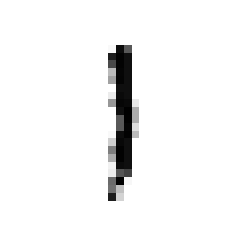

In [ ]:
im = PILImageBW.create(items[0])
im.show();

In [ ]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')(items)

In [ ]:
dsets = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=splits)

In [ ]:
dsets

(#70000) [(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4FE4C50>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4FC9910>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1850>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA19D0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1B10>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1C50>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1D90>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1ED0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1FD0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DA1BD0>, tensor(1))...]

In [ ]:
dsets.train

(#60000) [(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABB10>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABC50>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABD90>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABED0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABFD0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABBD0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF1D0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF410>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF550>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF690>, tensor(1))...]

In [ ]:
dsets.valid

(#10000) [(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA56D7F90>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAFE90>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF0D0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAF110>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAFFD0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DAB0D0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABF50>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABDD0>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABC90>, tensor(1)),(<fastai.vision.core.PILImageBW image mode=L size=28x28 at 0x7EFFA4DABB50>, tensor(1))...]

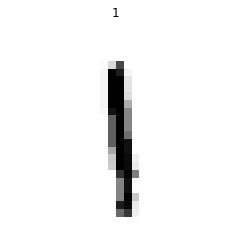

In [ ]:
show_at(dsets.train, 0);

In [ ]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]
bs = 128

In [ ]:
dls = dsets.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor, Normalize])

In [ ]:
dsrc1 = Datasets([items[0]]*128, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=[list(range(128)), []])

In [ ]:
dbunch1 = dsrc1.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor()])

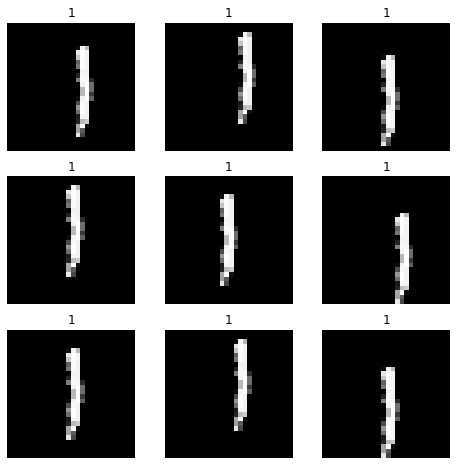

In [ ]:
dbunch1.show_batch(figsize=(8,8), cmap='gray')

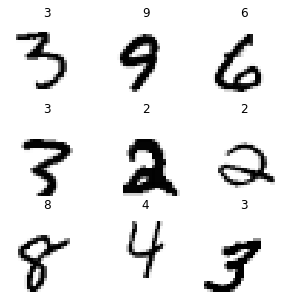

In [ ]:
dls.show_batch(figsize=(5,5))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

### Basic CNN with batchnorm

In [ ]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [ ]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 8 x 14 x 14    80         True      
________________________________________________________________
BatchNorm2d          128 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 128 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               128 x 16 x 7 x 7     1,168      True      
________________________________________________________________
BatchNorm2d          128 x 16 x 7 x 7     32         True      
________________________________________________________________
ReLU                 128 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               128 x 32 x 4 x 4     4,640      True      
______________________________________________________

In [ ]:
xb = xb.cuda()

In [ ]:
model(xb).shape

torch.Size([128, 10])

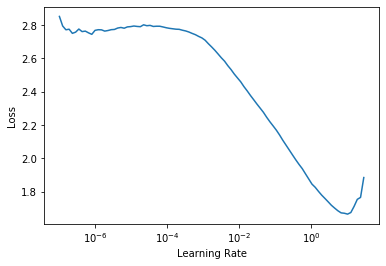

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.fit_one_cycle(3, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.213812,0.354680,0.892200,00:29
1,0.123005,0.114518,0.963900,00:14
2,0.080421,0.043124,0.986100,00:13


### Refactor

In [ ]:
def conv2(ni,nf): return ConvLayer(ni,nf,stride=2)

In [ ]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, lr_max=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.223311,0.193103,0.938700,00:12
1,0.177194,0.145610,0.951300,00:12
2,0.147710,0.119839,0.961600,00:13
3,0.121755,0.093231,0.970300,00:12
4,0.112889,0.073495,0.975600,00:12
5,0.094216,0.065282,0.979300,00:12
6,0.078794,0.048146,0.985600,00:12
7,0.058287,0.032482,0.989300,00:12
8,0.046136,0.025968,0.991600,00:12
9,0.041037,0.026425,0.990700,00:13


### Resnet-ish

In [ ]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf,nf)
        self.conv2 = ConvLayer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [ ]:
model = nn.Sequential(
    conv2(1, 8),
    ResBlock(8),
    conv2(8, 16),
    ResBlock(16),
    conv2(16, 32),
    ResBlock(32),
    conv2(32, 16),
    ResBlock(16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [ ]:
learn = Learner(dls, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

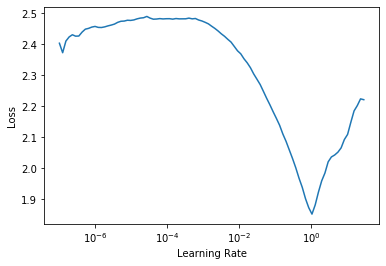

In [ ]:
learn.lr_find(end_lr=100)

In [ ]:
learn.fit_one_cycle(12, lr_max=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.183473,0.492155,0.854100,00:18
1,0.133731,0.188146,0.945000,00:17
2,0.089143,0.080600,0.974100,00:18
3,0.084515,0.052463,0.981700,00:18
4,0.061913,0.044865,0.987100,00:18
5,0.057088,0.059705,0.981400,00:18
6,0.054864,0.034580,0.988600,00:18
7,0.035986,0.031446,0.989900,00:17
8,0.032535,0.022280,0.992800,00:19
9,0.026329,0.018659,0.994300,00:17


In [ ]:
print(learn.summary())

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               128 x 8 x 14 x 14    72         True      
________________________________________________________________
BatchNorm2d          128 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 128 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               128 x 8 x 14 x 14    576        True      
________________________________________________________________
BatchNorm2d          128 x 8 x 14 x 14    16         True      
________________________________________________________________
ReLU                 128 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               128 x 8 x 14 x 14    576        True      
______________________________________________________

## fin